## 1. Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

## 2. Functions to load data

### 2.1 Load Reward Data

Load fitness log data from a CSV file.

Parameters:
- file_path (str): Path to the CSV file.

Returns:
- pd.DataFrame: DataFrame containing generations, rewards, and cycle identifiers.

In [20]:
def load_reward_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, header=None, names=["Generation", "Reward"])
    df["Cycle"] = (df["Generation"] == 0).cumsum()  # Identify cycles
    return df

### 2.2 Load Data for Torque Progression

Loads the best individuals' keyframes from a CSV file.

Each row in the CSV represents one individual with its keyframes concatenated.
Since each keyframe consists of 7 values, the total number of values in a row 
must be divisible by 7. The function reshapes the row into a 2D NumPy array where 
each row corresponds to one keyframe.

It also clips out-of-bound values:
    - For indices 0-5 (action/torque values), the allowed range is [-1, 1].
    - For index 6 (duration), the allowed range is [0, 100].

Parameters:
- file_path (str): Path to the CSV file containing best individuals.

Returns:
- list of np.ndarray: A list where each element is a 2D NumPy array representing 
                        an individual's keyframes.

In [21]:
def load_best_individuals(file_path: str):
    individuals = []
    with open(file_path, "r") as file:
        reader = csv.reader(file)
        for row in reader:
            # Skip empty or malformed rows (number of values must be divisible by 7)
            if not row or len(row) % 7 != 0:
                print(f"Skipping malformed row: {row}")
                continue

            try:
                values = np.array([float(x) for x in row])
                num_keyframes = len(values) // 7
                keyframes = values.reshape(num_keyframes, 7)
                
                # Clip out-of-bound values for each keyframe.
                for j in range(keyframes.shape[0]):
                    # For indices 0-5: allowed range is [-1, 1]
                    for i in range(6):
                        original = keyframes[j, i]
                        clipped = np.clip(original, -1, 1)
                        if clipped != original:
                            print(f"Clipping value {original} at keyframe {j}, index {i} to {clipped}")
                            keyframes[j, i] = clipped
                    # For index 6: allowed range is [0, 100]
                    original = keyframes[j, 6]
                    clipped = np.clip(original, 0, 100)
                    if clipped != original:
                        print(f"Clipping value {original} at keyframe {j}, index 6 to {clipped}")
                    keyframes[j, 6] = clipped

                individuals.append(keyframes)
            except ValueError as e:
                print(f"Error processing row {row}: {e}")
    return individuals

## 3. Functions to Plot Data

### 3.1 Plot Rewards Over Generations

Plot the reward progression over generations for different cycles.

Parameters:
- df (pd.DataFrame): DataFrame containing generations, rewards, and cycle identifiers.


In [24]:
def plot_fitness_progression(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    cycles = df["Cycle"].unique()
    colors = plt.cm.jet(np.linspace(0, 1, len(cycles)))  # Generate distinct colors

    for cycle, color in zip(cycles, colors):
        cycle_data = df[df["Cycle"] == cycle]
        plt.plot(
            cycle_data["Generation"],
            cycle_data["Reward"],
            label=f"Cycle {cycle}",
            color=color
        )

    plt.xlabel("Generation")
    plt.ylabel("Reward")
    plt.title("Reward Progression Over Generations")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
    plt.grid()
    plt.tight_layout()  # Adjust layout to prevent clipping

    plt.show()

### 3.2 Plot Torque Progression

Plots torque values for multiple individuals.

For each individual, each keyframe is plotted as a line with the x-axis 
representing the keyframe component index (0 to 5) and the y-axis representing 
the corresponding torque value (first 6 values of a keyframe). The 7th value (duration) 
is omitted.

Parameters:
- individuals (list of np.ndarray): List of 2D arrays where each array represents 
                                        an individual's keyframes.



In [ ]:
def plot_torques(individuals):
    plt.figure(figsize=(10, 6))
    
    colormap = plt.colormaps["viridis"]  # Retrieve colormap
    
    for idx, individual in enumerate(individuals):
        num_keyframes = individual.shape[0]
        colors = colormap(np.linspace(0, 1, num_keyframes))  # Generate unique colors per individual
        
        for k in range(num_keyframes):
            x = list(range(6))  # Keyframe component indices: 0 through 5 (torque values)
            y = individual[k, :6]  # First 6 torque values
            color = colors[k]  # Assign color from the colormap
            
            plt.plot(x, y, marker='o', linestyle='-', alpha=0.7,
                     markersize=3, linewidth=1, color=color,
                     label=f"Ind {idx} KF {k}" if num_keyframes < 10 else None)

    plt.xlabel("Keyframe Component Index")
    plt.ylabel("Torque Value")
    plt.title("Torque Variations in Generations")
    
    if sum(ind.shape[0] for ind in individuals) < 20:
        plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=8)
    
    plt.grid()
    plt.tight_layout()
    plt.savefig("best_individuals_plot.png", bbox_inches="tight")
    plt.show()
    
    print("Plot saved as best_individuals_plot.png")


## 4. Load Data and Plot

### 4.1 Rewards over Generations over Cycles

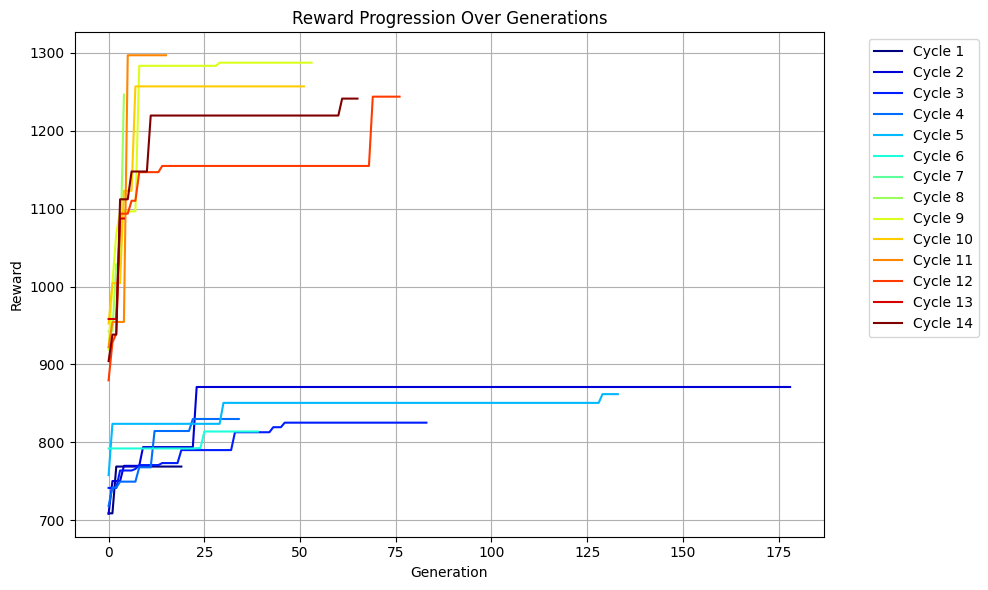

In [116]:
# Generate Fitness Progression Plot
FILE_PATH = "fitness_log.csv"

fitness_data = load_reward_data(FILE_PATH)
plot_fitness_progression(fitness_data)


### 4.2 Torque Progression for Best Individuals

Clipping value 8.211330805383016 at keyframe 1, index 5 to 1.0
Clipping value 1.0842005534749701 at keyframe 2, index 0 to 1.0
Clipping value -3.795067380256101 at keyframe 3, index 5 to -1.0
Clipping value 8.784418394504737 at keyframe 4, index 5 to 1.0
Clipping value 1.2685864065302501 at keyframe 5, index 1 to 1.0
Clipping value -1.5637301501318308 at keyframe 5, index 5 to -1.0
Clipping value 1.1317103270362139 at keyframe 6, index 3 to 1.0
Clipping value -1.5056282759905433 at keyframe 6, index 5 to -1.0
Clipping value 8.211330805383016 at keyframe 1, index 5 to 1.0
Clipping value 1.0842005534749701 at keyframe 2, index 0 to 1.0
Clipping value -3.795067380256101 at keyframe 3, index 5 to -1.0
Clipping value 8.784418394504737 at keyframe 4, index 5 to 1.0
Clipping value 1.2685864065302501 at keyframe 5, index 1 to 1.0
Clipping value -1.5637301501318308 at keyframe 5, index 5 to -1.0
Clipping value 1.1317103270362139 at keyframe 6, index 3 to 1.0
Clipping value -1.5056282759905433 a

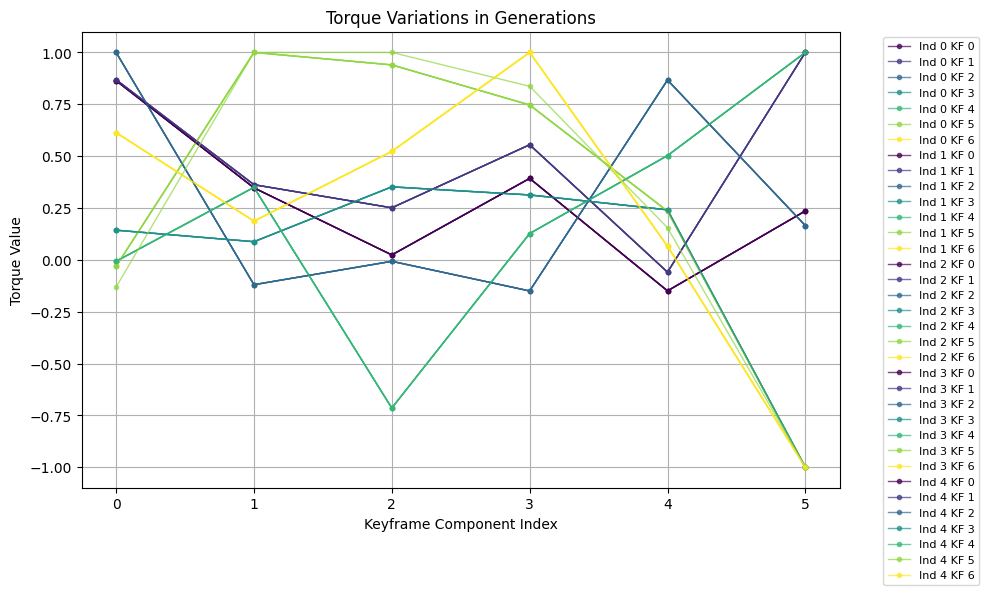

Plot saved as best_individuals_plot.png


In [117]:
# Generate Best Individuals' Keyframe Plot
best_ind_file = "data/best_individual.csv"


individuals = load_best_individuals(best_ind_file)
if individuals:
    plot_torques(individuals)
else:
    print("No valid data found in CSV.")

In [ ]:


# ============================
# Section 1: Method Definitions
# ============================








# ============================
# Section 2: Plot Generation
# ============================

# Generate Fitness Progression Plot
FILE_PATH = "fitness_log.csv"
OUTPUT_PATH = "fitness_plot.png"




# ============================
# Section 3: Conclusion
# ============================
#
# This script generated two important visualizations:
#
# 1. Reward Progression Over Generations:
#    - Shows the evolution of rewards over multiple cycles.
#    - Helps track performance improvements over generations.
#
# 2. Torque Variations in Generations:
#    - Displays the torque values (first six values of keyframes) for best individuals.
#    - Duration values (7th component) are omitted.
#
# Together, these plots provide insights into both the overall optimization performance and the detailed 
# evolution of the keyframe parameters.
